# This is an example that shows the application of the WP module for the TF coils

## Some import

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bluemira.base.constants import MU_0, MU_0_2PI, MU_0_4PI
from bluemira.base.look_and_feel import bluemira_print
from bluemira.magnets.cable import DummyRoundCableHTS, DummyRoundCableLTS, DummyRectangularCableLTS, \
    DummyRectangularCableHTS
from bluemira.magnets.case_tf import CaseTF
from bluemira.magnets.conductor import SymmetricConductor
from bluemira.magnets.materials import AISI_316LN, Copper300, DummyInsulator
from bluemira.magnets.strand import Strand, WireNb3Sn
from bluemira.magnets.utils import (
    delayed_exp_func,
)
from bluemira.magnets.winding_pack import WindingPack

## Plot options

In [2]:
# Enable interactive mode
# %matplotlib notebook

show = True
homogenized = False


## Input (and derived) values
*Note: these values shall be provided internally by bluemira code (as reactor settings or as information coming from the TF coils builder)<br><br>

**Machine (generic)**

In [3]:
R0 = 8.6  # [m] major machine radius
B0 = 4.39  # [T] magnetic field @R0
A = 2.8 # machine aspect ratio
n_TF = 16  # number of TF coils
ripple = 6e-3 # requirement on the maximum plasma ripple

a = R0 / A # minor radius

**Inputs for the TF coils**

In [4]:
d = 1.9 # additional distance to calculate the max external radius of the inner TF leg
Iop = 60.0e3  # operational current in each conductor
dr_plasma_side = R0 * 2 / 3 * 1e-2 # thickness of the plate before the WP
T_sc = 4.2  # operational temperature of superconducting cable
T_margin = 1.5  # temperature margin
T0 = T_sc + T_margin # temperature considered for the superconducting cable
t_delay = 3 #[s]
t0 = 0 #[s]
hotspot_target_temperature = 250.0 #[K]

Ri = R0 - a - d  # [m] max external radius of the internal TF leg
Re = (R0 + a) * (1 / ripple) ** (1 / n_TF)  # [m] max internal radius of the external TF leg
I_TF = B0 * R0 / MU_0_2PI / n_TF  # total current in each TF coil

# magnetic field generated by the TF coils with a correction factor that takes into account the ripple
B_TF_r = lambda I_TF, n_TF, R: 1.08 * (MU_0_2PI * n_TF * I_TF / R)
B_TF_i = B_TF_r(I_TF, n_TF, Ri)  # max magnetic field on the inner TF leg
pm = B_TF_i ** 2 / (2 * MU_0)  # magnetic pressure on the inner TF leg

# vertical tension acting on the equatorial section of inner TF leg
# i.e. half of the whole F_Z
t_z = 0.5 * np.log(Re / Ri) * MU_0_4PI * n_TF * I_TF ** 2

n_cond = np.floor(I_TF / Iop) # minimum number of conductors
bluemira_print(f"Total number of conductor: {n_cond}")

+-------------------------------------------------------------------------+
| Total number of conductor: 196.0                                        |
+-------------------------------------------------------------------------+


***Additional data***

In [5]:
R_VV = Ri * 1.05  # Vacuum vessel radius
S_VV = 90e6  # Vacuum vessel steel limit

# allowable stress values
safety_factor = 1.5 * 1.3
S_Y = 1e9 / safety_factor  # [Pa] steel allowable limit


## Calculation of the maximum discharge time for the TF coils

In [6]:
# inductance (here approximated... better estimation in bluemira)
L = MU_0 * R0 * (n_TF * n_cond) ** 2 * (1 - np.sqrt(1 - (R0 - Ri) / R0)) / n_TF * 1.1
# Magnetic energy
E = 1 / 2 * L * n_TF * Iop ** 2 * 1e-9
# Maximum tension... (empirical formula from Lorenzo... find a generic equation)
V_MAX = (7 * R0 - 3) / 6 * 1.1e3
# Discharge characteristic times
Tau_discharge1 = L * Iop / V_MAX
Tau_discharge2 = B0 * I_TF * n_TF * (R0 / A) ** 2 / (R_VV * S_VV)
# Discharge characteristic time to be considered in the following
Tau_discharge = max([Tau_discharge1, Tau_discharge2])
tf = Tau_discharge
bluemira_print(f"Maximum TF discharge time: {tf}")

+-------------------------------------------------------------------------+
| Maximum TF discharge time: 22.798740257170234                           |
+-------------------------------------------------------------------------+


## Current and magnetic field behaviour during discharge


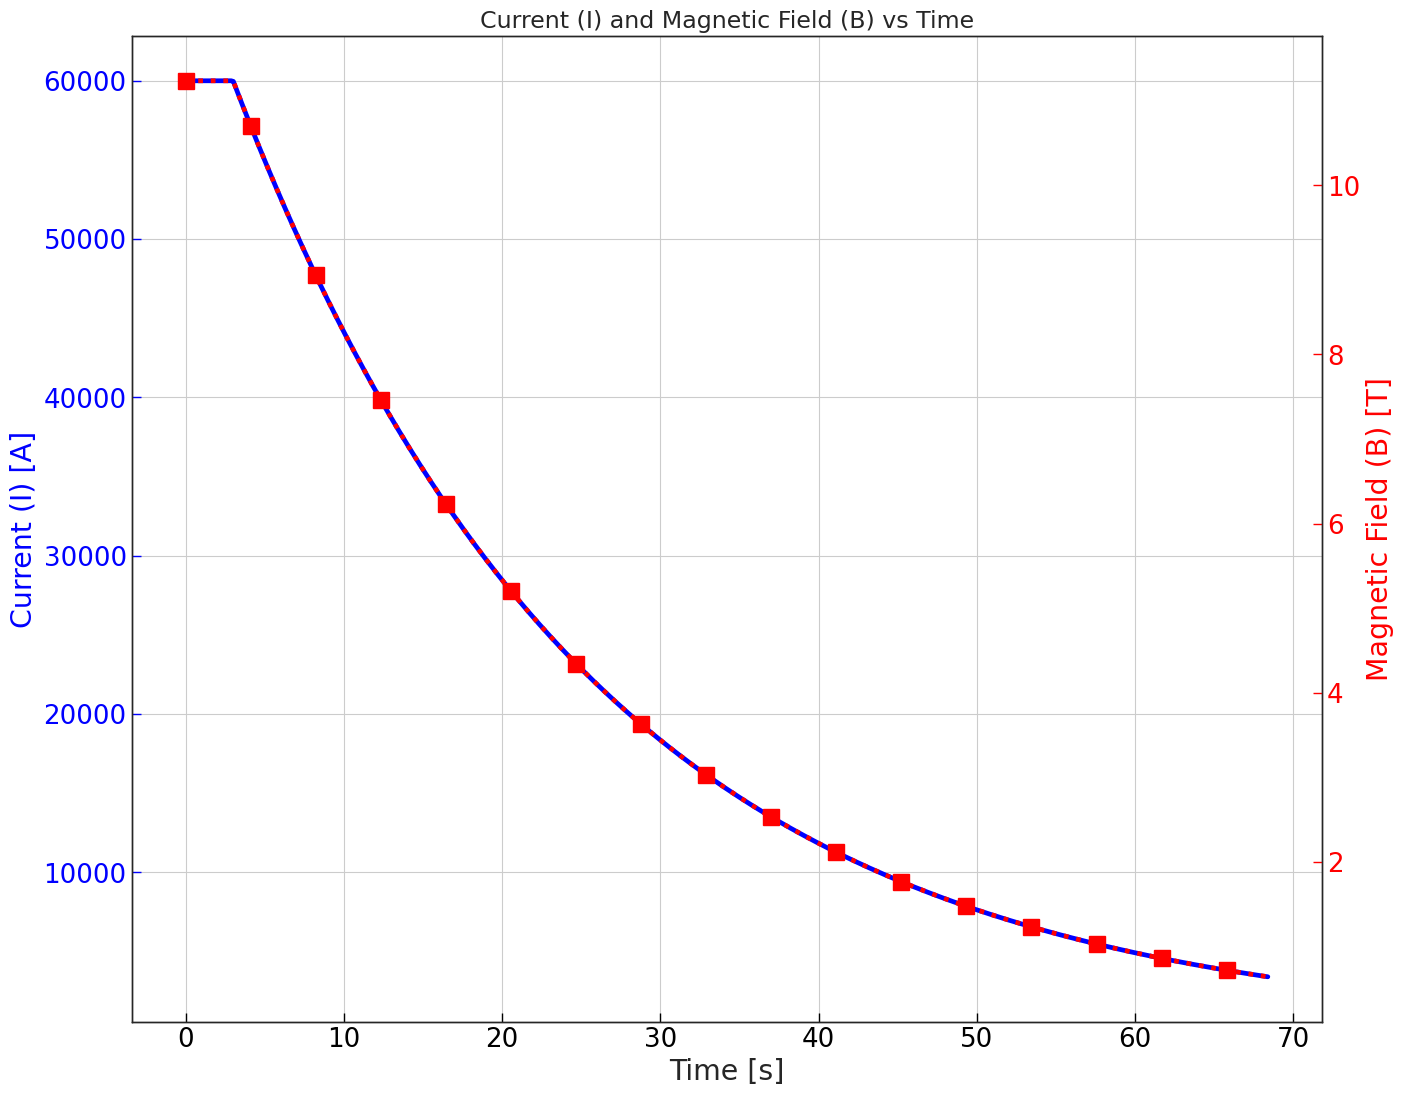

In [7]:
I = delayed_exp_func(Iop, Tau_discharge, t_delay)
B = delayed_exp_func(B_TF_i, Tau_discharge, t_delay)

# Create a time array from 0 to 3*Tau_discharge
t = np.linspace(0, 3 * Tau_discharge, 500)
I_data = np.array([I(t_i) for t_i in t])
B_data = np.array([B(t_i) for t_i in t])

# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot I on the left y-axis
ax1.plot(t, I_data, 'b-o', label='Current (I)', markevery=30) 
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Current (I) [A]', color='b')
ax1.tick_params('y', colors='b')

# Create a twin y-axis for the magnetic field B
ax2 = ax1.twinx()
ax2.plot(t, B_data, 'r:s', label='Magnetic Field (B)', markevery=30)
ax2.set_ylabel('Magnetic Field (B) [T]', color='r')
ax2.tick_params('y', colors='r')

# Add grid and title
ax1.grid(True)
plt.title('Current (I) and Magnetic Field (B) vs Time')

# Show the plot
plt.show()

### Define materials (at the beginning the conductor is defined with a dummy number of stabilizer strands)

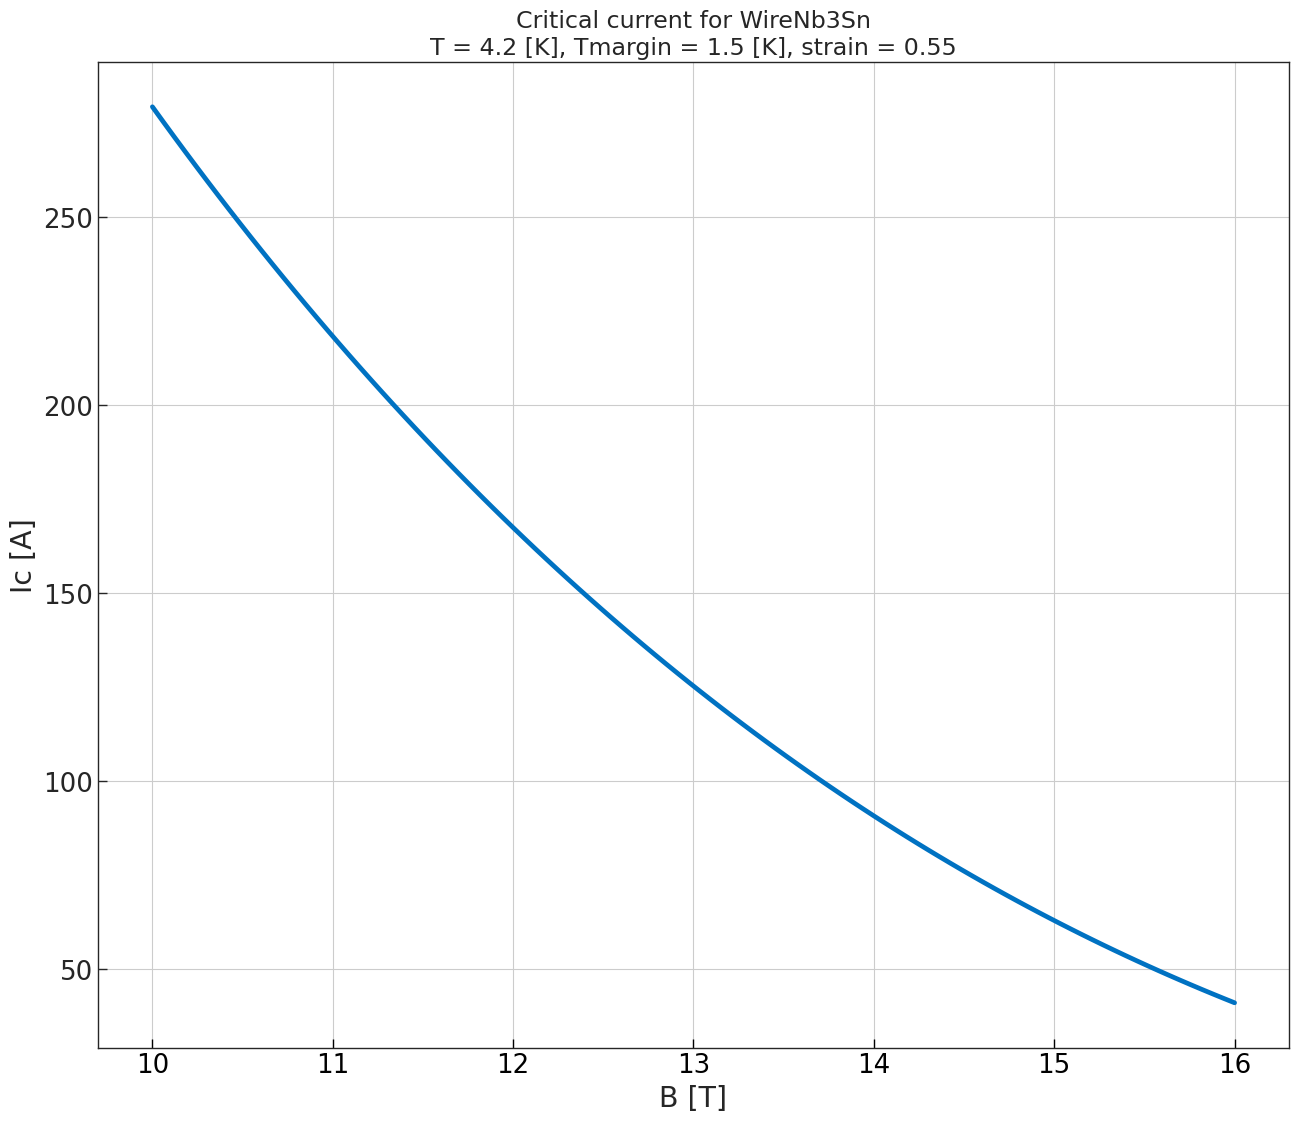

<Axes: title={'center': 'Critical current for WireNb3Sn\nT = 4.2 [K], Tmargin = 1.5 [K], strain = 0.55'}, xlabel='B [T]', ylabel='Ic [A]'>

In [8]:
ss316 = AISI_316LN()
sc_strand = WireNb3Sn(d_strand=1e-3)
copper300 = Copper300()
insulator = DummyInsulator()
stab_strand = Strand([copper300], [1], d_strand=1.0e-3)

# plot the critical current in a range of B between [10,16]
Bt_arr = np.linspace(10, 16, 100)
sc_strand.plot_Ic_B(Bt_arr, T=T_sc, T_margin=T_margin)


#### Plot number of conductor vs Iop

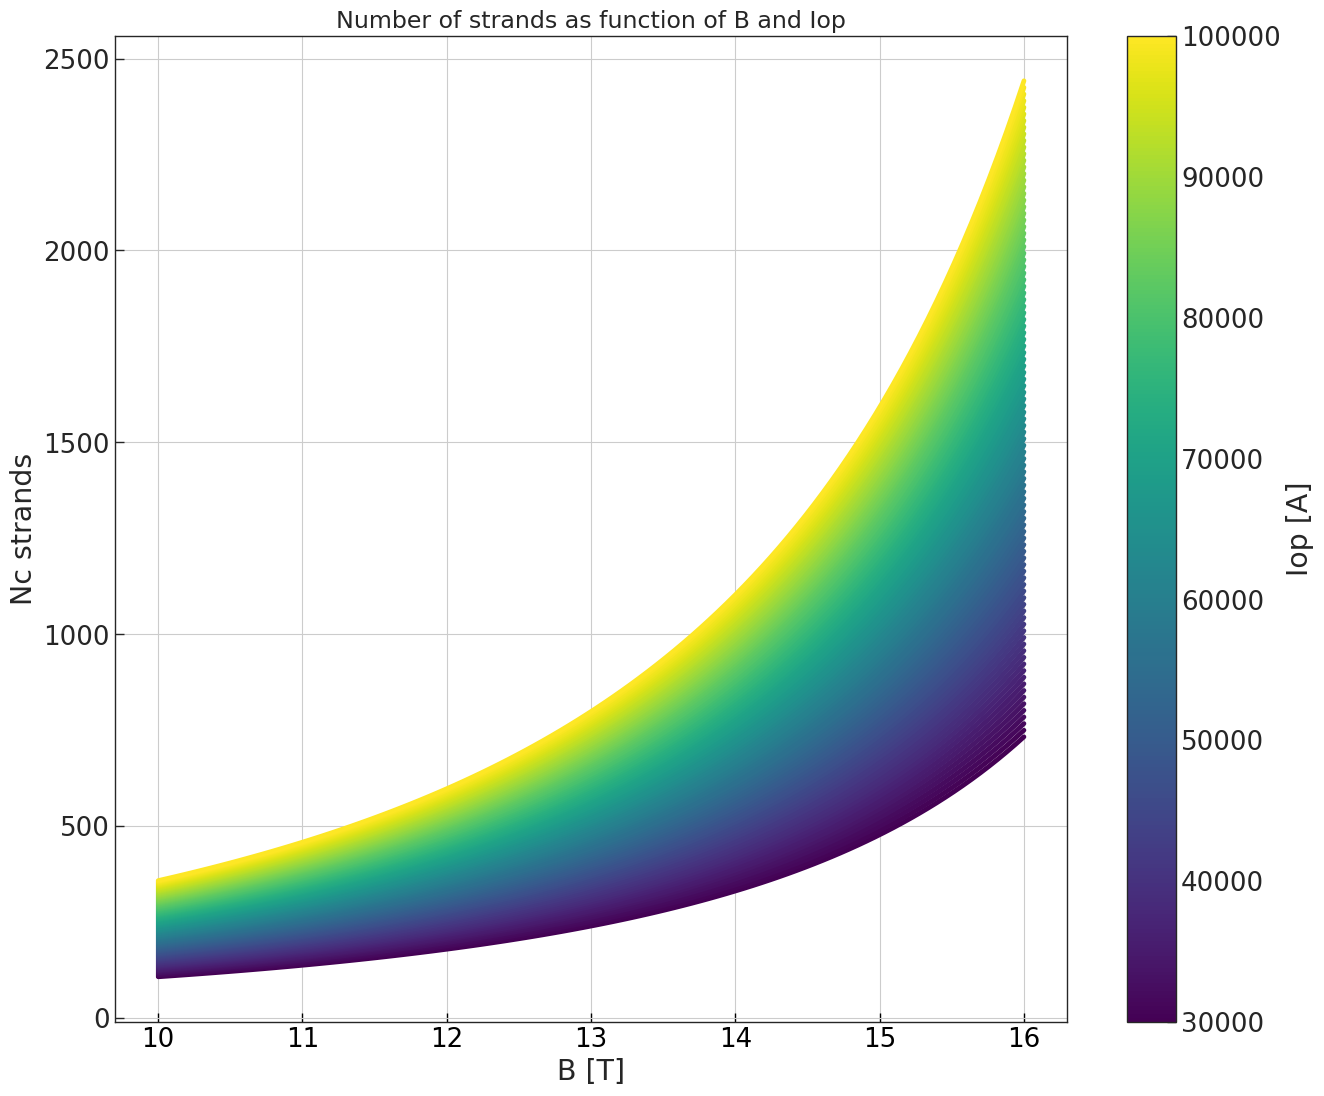

In [9]:
# Define the range of operating current (Iop) values
Iop_range = np.linspace(30, 100, 100) * 1e3  # 5 equally spaced values between 30 and 100 A
Ic_sc_arr = sc_strand.Ic(B=Bt_arr, T=T_sc, T_margin=T_margin)

# Create a colormap to assign colors to different Iop values
import matplotlib.cm as cm  # Import colormap

colors = cm.viridis(np.linspace(0, 1, len(Iop_range)))  # Use the 'viridis' colormap

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the number of superconducting strands as a function of B for different Iop values
for Iop_ref, color in zip(Iop_range, colors):
    n_sc_strand = Iop_ref / Ic_sc_arr  # Calculate number of strands
    ax.plot(Bt_arr, n_sc_strand, color=color, label=f'Iop = {Iop} A')
    # Add plot title, axis labels, and grid
ax.set_title('Number of strands as function of B and Iop')  # Title
ax.set_xlabel('B [T]')  # X-axis label
ax.set_ylabel('Nc strands')  # Y-axis label
ax.grid(True)

# Create a ScalarMappable to map colors to the colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=Iop_range.min(), vmax=Iop_range.max()))
sm.set_array([])  # Dummy array for the ScalarMappable

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Iop [A]')  # Label the colorbar

# Show the plot
plt.show()


**Calculate number of superconducting strands considering the strand critical current at B_TF_i and T_sc + T_margin**

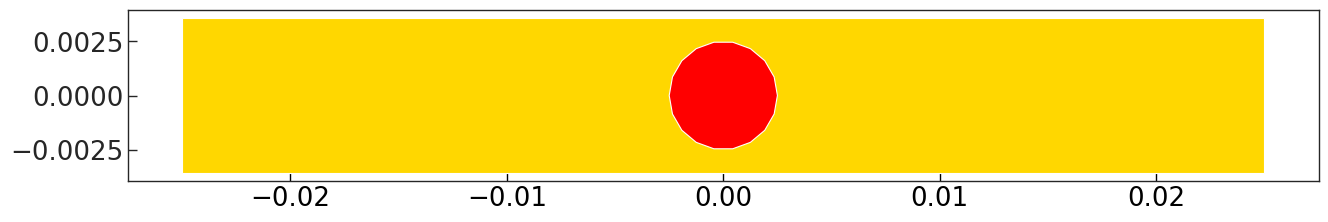

+-------------------------------------------------------------------------+
| cable area: 0.0003597042619477489                                       |
+-------------------------------------------------------------------------+


In [10]:
Ic_sc = sc_strand.Ic(B=B_TF_i, T=T_sc, T_margin=T_margin)
n_sc_strand = int(np.ceil(Iop / Ic_sc))

###########################################################
dx = 0.05 # cable length... just a dummy value
B_ref = 15 #[T] Reference B field value (limit for LTS)

if B_TF_i < B_ref:
    cable = DummyRectangularCableLTS(
        dx=dx, sc_strand=sc_strand, stab_strand=stab_strand, n_sc_strand=n_sc_strand, n_stab_strand=1, d_cooling_channel=5e-3, void_fraction=0.7, cos_theta=0.97
    )
else:
    cable = DummyRectangularCableHTS(
        dx=dx, sc_strand=sc_strand, stab_strand=stab_strand, n_sc_strand=n_sc_strand, n_stab_strand=1,
        d_cooling_channel=5e-3, void_fraction=0.7, cos_theta=0.97
    )
cable.plot(0, 0, show=True)
bluemira_print(f"cable area: {cable.area}")

***Change cable aspect ratio***

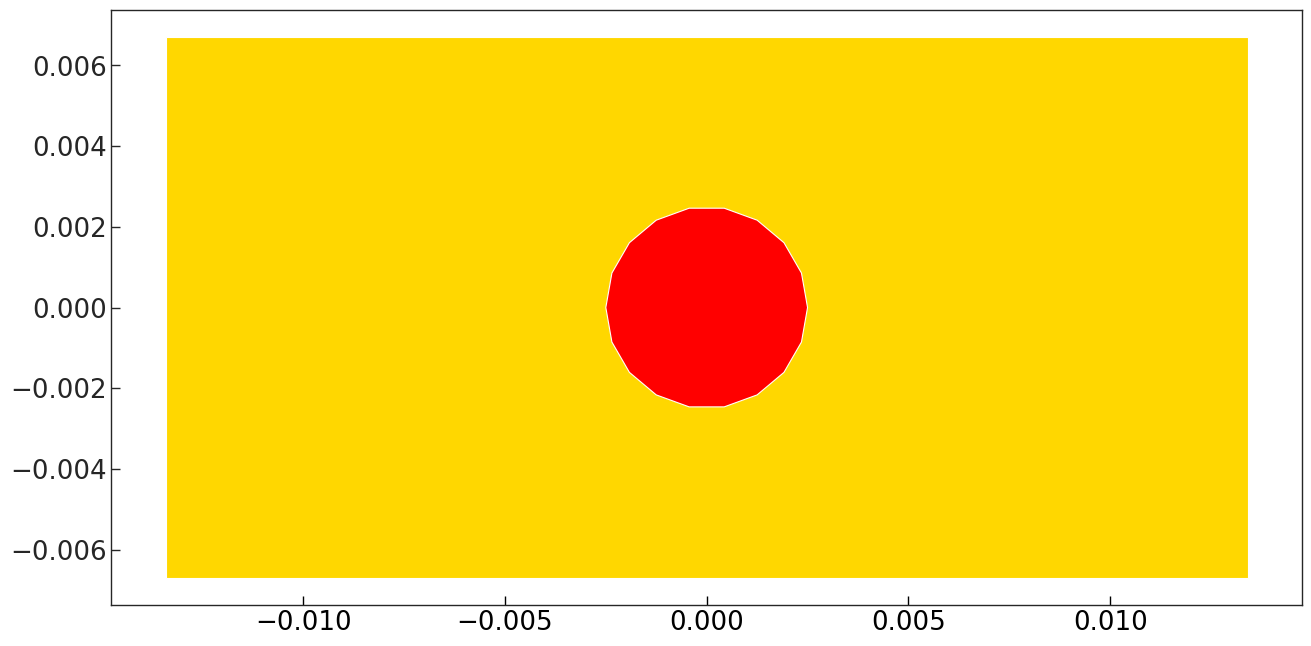

+-------------------------------------------------------------------------+
| cable area: 0.0003597042619477489                                       |
+-------------------------------------------------------------------------+


In [11]:
cable.set_aspect_ratio(2)  # This adjusts the cable dimensions while maintaining the total cross-sectional area.
cable.plot(0, 0, show=True)
bluemira_print(f"cable area: {cable.area}")

+-------------------------------------------------------------------------+
| before optimization: dx_cable = 0.026821791959067497, aspect ratio =    |
| 2.0                                                                     |
+-------------------------------------------------------------------------+
+-------------------------------------------------------------------------+
| Optimal n_stab: 446                                                     |
+-------------------------------------------------------------------------+
+-------------------------------------------------------------------------+
| Final temperature with optimal n_stab: 249.37866723584887 Kelvin        |
+-------------------------------------------------------------------------+


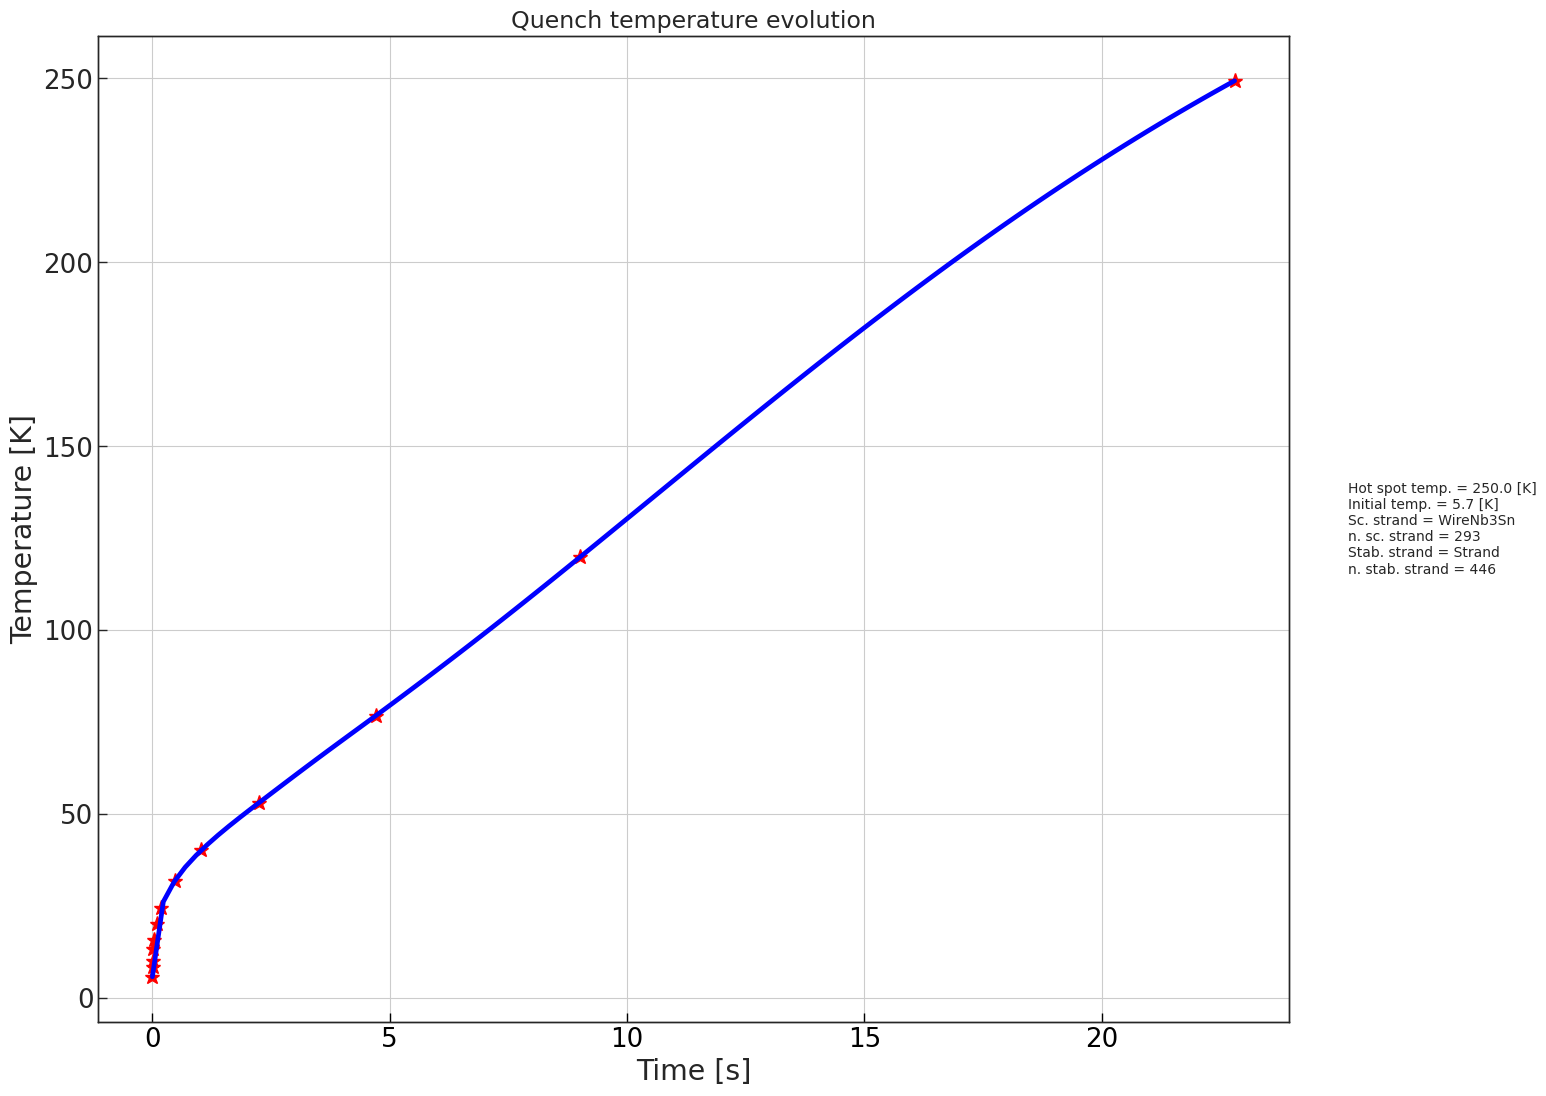

+-------------------------------------------------------------------------+
| after optimization: dx_cable = 0.026821791959067497, aspect ratio =     |
| 0.8227123912827806                                                      |
+-------------------------------------------------------------------------+
+-------------------------------------------------------------------------+
| Adjust aspect ratio: dx_cable = 0.04181949347006068, aspect ratio =     |
| 2.0000000000000004                                                      |
+-------------------------------------------------------------------------+


In [12]:
# optimize the number of stabilizer strands using the hot spot criteria.
# Note: optimize_n_stab_ths changes adjust cable.dy while maintaining cable.dx. It could be possible to add a parameter
#       maintain constant the aspect ratio if necessary.
bluemira_print(f"before optimization: dx_cable = {cable.dx}, aspect ratio = {cable.aspect_ratio}")
T_for_hts = T0
result = cable.optimize_n_stab_ths(
    t0, tf, T_for_hts, hotspot_target_temperature, B, I, bounds=[1, 10000], show=show
)
bluemira_print(f"after optimization: dx_cable = {cable.dx}, aspect ratio = {cable.aspect_ratio}")

cable.set_aspect_ratio(2)
bluemira_print(f"Adjust aspect ratio: dx_cable = {cable.dx}, aspect ratio = {cable.aspect_ratio}")

In [13]:
###########################################################
# Create a conductor with the specified cable
conductor = SymmetricConductor(
    cable=cable, mat_jacket=ss316, mat_ins=insulator, dx_jacket=0.01, dx_ins=1e-3
)

+-------------------------------------------------------------------------+
| WARNING: 2.0/198 have been added to complete the last winding pack      |
| (nx=18, ny=11).                                                         |
+-------------------------------------------------------------------------+


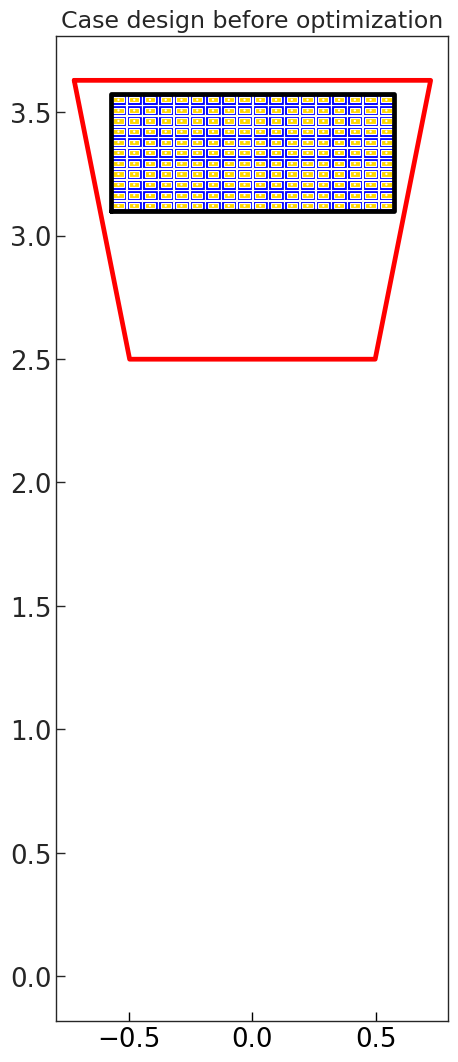

+-------------------------------------------------------------------------+
| Previous number of conductors: 196.0                                    |
+-------------------------------------------------------------------------+
+-------------------------------------------------------------------------+
| New number of conductors: 198                                           |
+-------------------------------------------------------------------------+


In [14]:
# case parameters
layout = "auto" #"layer" or "pancake"
wp_reduction_factor = 0.8
min_gap_x = 0.01
n_layers_reduction = 4

# creation of the case
wp1 = WindingPack(conductor, 1, 1)  # just a dummy WP to create the case
case = CaseTF(
    Ri=Ri,
    dy_ps=dr_plasma_side,
    dy_vault=0.6,
    theta_TF=360 / n_TF,
    mat_case=ss316,
    WPs=[wp1],
)

# arrangement of conductors into the winding pack and case
case.rearrange_conductors_in_wp(n_conductors=n_cond, cond=conductor, R_wp_i=case.R_wp_i, wp_reduction_factor=wp_reduction_factor, min_gap_x=min_gap_x,
                                n_layers_reduction=n_layers_reduction, layout=layout)

ax = case.plot(show=False, homogenized=False)
ax.set_title("Case design before optimization")
plt.show()

bluemira_print(f"Previous number of conductors: {n_cond}")
bluemira_print(f"New number of conductors: {case.n_conductors}")

## Optimize cable jacket and case vault thickness

+-------------------------------------------------------------------------+
| WARNING: 4.0/200 have been added to complete the last winding pack      |
| (nx=20, ny=10).                                                         |
+-------------------------------------------------------------------------+
+-------------------------------------------------------------------------+
| WARNING: 4.0/200 have been added to complete the last winding pack      |
| (nx=20, ny=10).                                                         |
+-------------------------------------------------------------------------+
+-------------------------------------------------------------------------+
| WARNING: 4.0/200 have been added to complete the last winding pack      |
| (nx=20, ny=10).                                                         |
+-------------------------------------------------------------------------+
+-------------------------------------------------------------------------+
| WARNING: 4

Internal optimazion - iteration 1
before optimization: conductor jacket area = 0.00165458480410182
Optimal dx_jacket: 0.00564775836281768
Averaged sigma in the x-direction: 515.4370047801681 MPa
235961.49362376195
after optimization: conductor jacket area = 0.0008361478800221115
before optimization: case dy_vault = 0.6
after optimization: case dy_vault = 0.19994399608392133
err_dy_jacket = 0.494647915326402
err_dy_vault = 2.0008402940399646
tot_err = 2.4954882093663664
Internal optimazion - iteration 2
before optimization: conductor jacket area = 0.0008361478800221115
Optimal dx_jacket: 0.0056720954534214725
Averaged sigma in the x-direction: 514.8510609286991 MPa
237293.93259759306
after optimization: conductor jacket area = 0.0008403031436586584
before optimization: case dy_vault = 0.19994399608392133
after optimization: case dy_vault = 0.19994399608392133
err_dy_jacket = 0.004969531988094018
err_dy_vault = 0.0
tot_err = 0.004969531988094018
Internal optimazion - iteration 3
before o

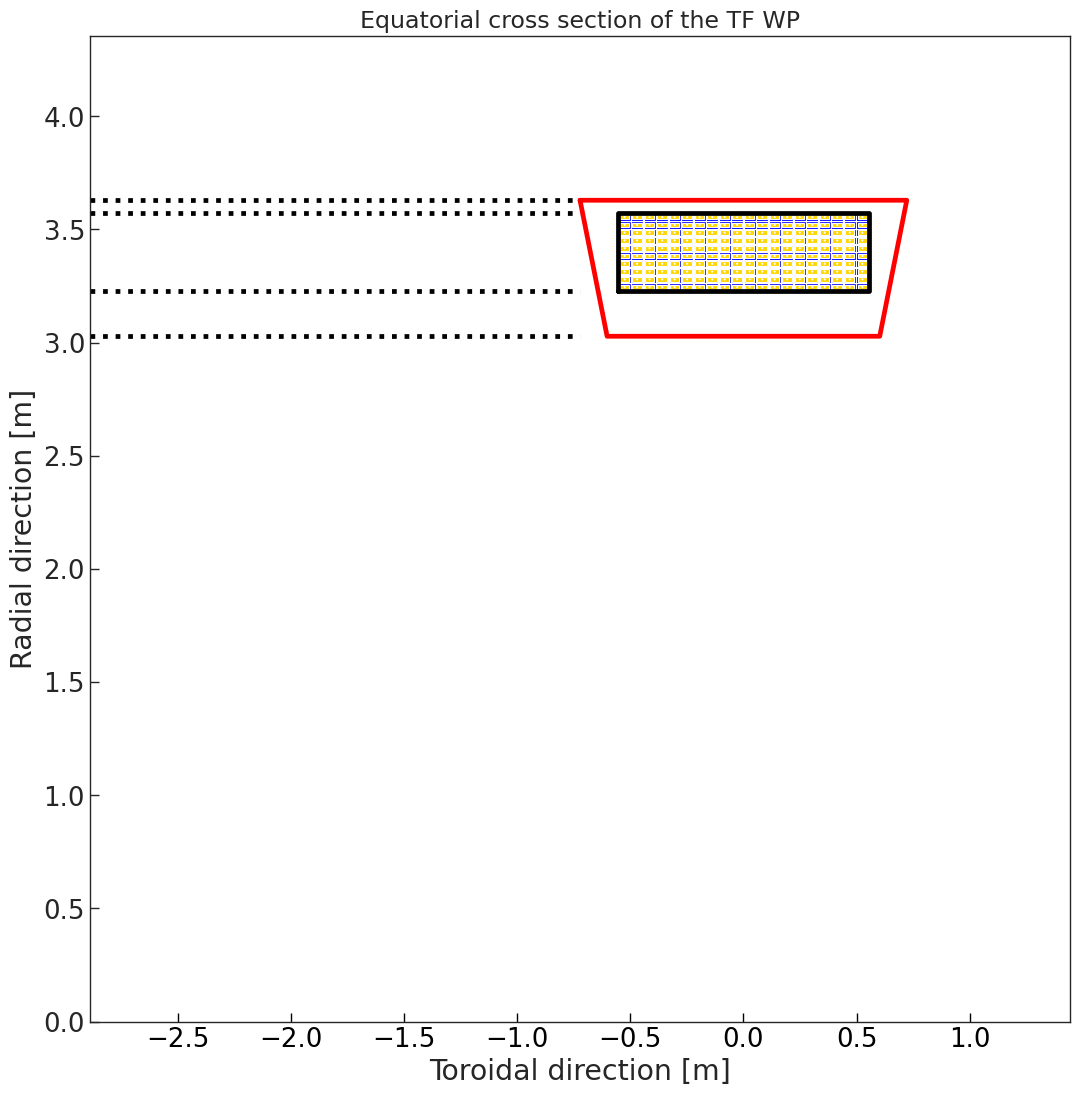

In [15]:
# Optimization parameters
bounds = [1e-5, 0.2] 
max_niter = 10
err = 1e-3

case.optimize_jacket_and_vault( pm, t_z, T0, B_TF_i, S_Y, bounds, layout, wp_reduction_factor,
                                min_gap_x, n_layers_reduction, max_niter, err, n_cond)

if show:
    scalex = np.array([2, 1])
    scaley = np.array([1, 1.2])

    ax = case.plot(homogenized=homogenized)
    ax.set_aspect("equal")

    # Fix the x and y limits
    ax.set_xlim(-scalex[0] * case.dx_i, scalex[1] * case.dx_i)
    ax.set_ylim(scaley[0] * 0, scaley[1] * case.Ri)

    deltax = [-case.dx_i / 2, case.dx_i / 2]

    ax.plot([-scalex[0] * case.dx_i, -case.dx_i / 2], [case.Ri, case.Ri], "k:")

    for i in range(len(case.WPs)):
        ax.plot(
            [-scalex[0] * case.dx_i, -case.dx_i / 2],
            [case.R_wp_i[i], case.R_wp_i[i]],
            "k:",
        )

    ax.plot(
        [-scalex[0] * case.dx_i, -case.dx_i / 2],
        [case.R_wp_k[-1], case.R_wp_k[-1]],
        "k:",
    )
    ax.plot([-scalex[0] * case.dx_i, -case.dx_i / 2], [case.Rk, case.Rk], "k:")

    ax.set_title("Equatorial cross section of the TF WP")
    ax.set_xlabel("Toroidal direction [m]")
    ax.set_ylabel("Radial direction [m]")

    plt.show()

In [16]:
# new operational current
bluemira_print(f"Operational current after optimization: {I_TF/case.n_conductors}")

+-------------------------------------------------------------------------+
| Operational current after optimization: 58990.625                       |
+-------------------------------------------------------------------------+
